## Setup

In [1]:
import numpy as np
import pandas as pd

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


Initially this returns a dataset of (text, label pairs):

In [3]:
df = pd.read_csv('https://www.dropbox.com/scl/fi/gjl0z298kxs3n78e1mj9l/training_data_companydata_adjusted_by_keywords.csv?rlkey=gfexpgeo6hrybtn9un2r2t399&dl=1')
df = df.groupby('text').max().reset_index()

print('10 random samples:')
display(df.sample(10))

stakeholder = 'INV'
df['label'] = df[stakeholder]
df = df[['text', 'label']].groupby('text').max().reset_index()

print('labels:')
print(df['label'].value_counts())

10 random samples:


,text,performance,CUS,INV,EMP,SOC
3942,Provisions in our organizational documents and...,0,0,0,0,0
5270,The required reserves may change due to new de...,0,0,0,0,0
2071,Exchange-traded derivatives consist of foreign...,0,0,0,0,0
1505,Business disruptions and interruptions due to ...,0,0,0,0,0
6039,We generally use prices from the pricing servi...,0,0,0,0,0
3827,"Our success largely depends on the skills, exp...",1,0,0,1,0
546,A downgrade of the financial strength rating o...,1,1,1,0,0
6525,the continued uncertain global economic enviro...,0,0,0,0,0
1303,Banking regulators also have broad supervisory...,0,0,0,0,0
1755,Credit metrics are monitored throughout the ye...,0,0,0,0,0


labels:
0    4298
1    2266
Name: label, dtype: int64


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [4]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [5]:
!mkdir knowledge_data
!mkdir knowledge_data/neg
!mkdir knowledge_data/pos

In [6]:
for i in df[df['label']==0].index:
  txt = df.iloc[i]['text']
  text_file = open(f"knowledge_data/neg/{i}.txt", "wt")
  text_file.write(txt)
  text_file.close()
for i in df[df['label']==1].index:
  txt = df.iloc[i]['text']
  text_file = open(f"knowledge_data/pos/{i}.txt", "wt")
  text_file.write(txt)
  text_file.close()

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'knowledge_data',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_dataset = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_dataset = tf.keras.utils.text_dataset_from_directory(
    'knowledge_data',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 6564 files belonging to 2 classes.
Using 5252 files for training.
Found 6564 files belonging to 2 classes.
Using 1312 files for validation.


In [8]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Truist competes with banks and other financial institutions for deposits and as a result, could risk losing deposits in the future or see an increase in costs associated with maintaining deposits.  '
 b'   Experts providing input to the various estimates and underlying assumptions include actuaries, underwriters, claim personnel and lawyers, as well as other members of management .  Therefore ,  management may have to consider varying individual viewpoints as part of its estimation of claims and claim adjustment expense reserves.  '
 b'In our portfolios for early-stage and mid-stage privately held companies, many of our loans are made to companies with modest or negative cash flows and/or no established record of profitable operations, primarily within the technology and life science and healthcare industries.  Consequently, repayment of these loans is often dependent upon receipt by our borrowers of additional financing from venture capitalists or others, or in some cases, 

In [9]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [10]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'of', 'to', 'and', 'in', 'a', 'or', 'our',
       'as', 'due', 'for', 'are', 'that', 'on', 'result', 'may', 'we',
       'is'], dtype='<U15')

In [11]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[824,   1,  24, 360,   5,  25,  26, 329,  12, 277,   5,  10,   7,
         16,  27,  35,   1, 277,   6,   2,  84,   8, 967,  31,  43,   6,
         97, 205,  24,   1, 277,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [  1,   1,   1,   4,   2, 349, 224,   5, 350, 175, 353,   1,   1,
        330, 892,   5,   1,  10, 145,  10,  25,   1,   3,  88,  56,  88,
         17,  30,   4,   1,   1, 561,   1,  10, 347,   3,  46, 863,   3,
        150,   5, 330, 584, 122, 190,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [  6,   9, 716,  12,   1,   5,   1,   1, 334, 220

In [12]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Truist competes with banks and other financial institutions for deposits and as a result, could risk losing deposits in the future or see an increase in costs associated with maintaining deposits.  '
Round-trip:  truist [UNK] with banks and other financial institutions for deposits and as a result could risk [UNK] deposits in the future or see an increase in costs associated with [UNK] deposits                                                    

Original:  b'   Experts providing input to the various estimates and underlying assumptions include actuaries, underwriters, claim personnel and lawyers, as well as other members of management .  Therefore ,  management may have to consider varying individual viewpoints as part of its estimation of claims and claim adjustment expense reserves.  '
Round-trip:  [UNK] [UNK] [UNK] to the various estimates and underlying assumptions include [UNK] [UNK] claim personnel and [UNK] as well as other [UNK] of management therefore management 

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

The code to implement this is below:

In [13]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [14]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [15]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

accuracy = tf.metrics.BinaryAccuracy()
recall = tf.metrics.Recall()
precision = tf.metrics.Precision()
metrics = [accuracy, recall, precision]

In [16]:
model.compile(loss=loss,
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=metrics)

## Train the model

In [17]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
165/165 [==============================] - 36s 127ms/step - loss: 0.6559 - binary_accuracy: 0.6582 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.6233 - val_binary_accuracy: 0.6490 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/10
165/165 [==============================] - 3s 20ms/step - loss: 0.5867 - binary_accuracy: 0.6582 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.5547 - val_binary_accuracy: 0.6469 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/10
165/165 [==============================] - 3s 20ms/step - loss: 0.4981 - binary_accuracy: 0.7032 - recall: 0.1677 - precision: 0.8224 - val_loss: 0.4545 - val_binary_accuracy: 0.7833 - val_recall: 0.4731 - val_precision: 0.8316
Epoch 4/10
165/165 [==============================] - 4s 26ms/step - loss: 0.3995 - binary_accuracy: 0.8176 - recall: 0.5933 - precision: 0.8237 - val_loss: 0.3951 - val_binary_accuracy: 0.8260 - val_recall: 0.6325 - val_precision: 0.8538
Epoch 5/10

In [18]:
loss, accuracy, recall, precision = model.evaluate(test_dataset)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1: {2 * recall * precision / (recall + precision)}')

41/41 [==============================] - 0s 10ms/step - loss: 0.3377 - binary_accuracy: 0.8659 - recall: 0.7834 - precision: 0.8330
Loss: 0.33770522475242615
Accuracy: 0.8658536672592163
Recall: 0.7834395170211792
Precision: 0.8329570889472961
F1: 0.8074398288819028


In [19]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'binary_accuracy', 'recall', 'precision', 'val_loss', 'val_binary_accuracy', 'val_recall', 'val_precision'])


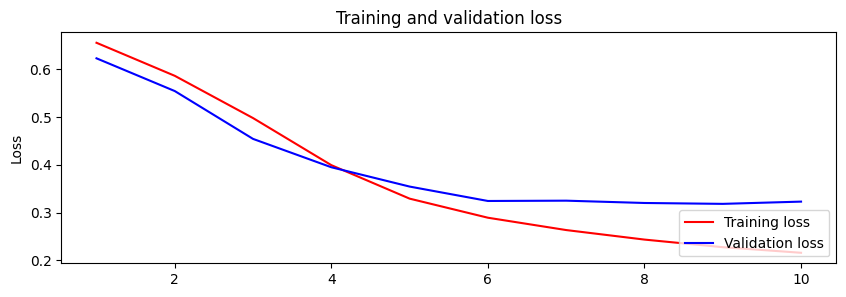

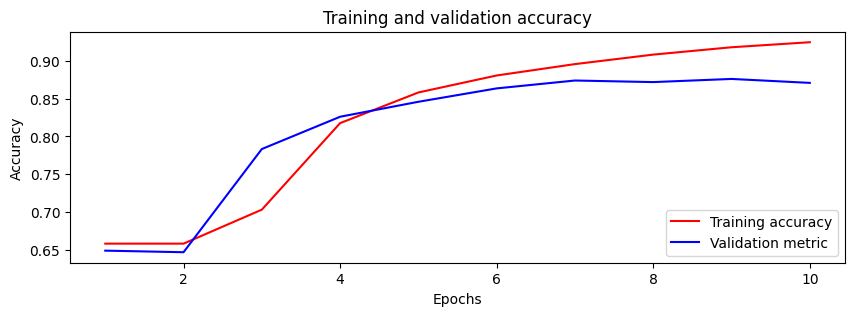

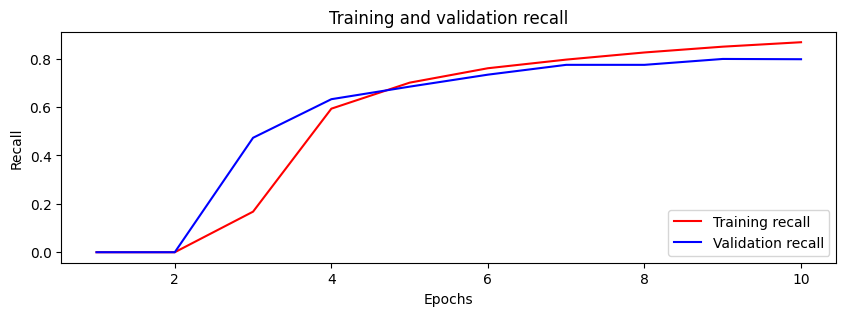

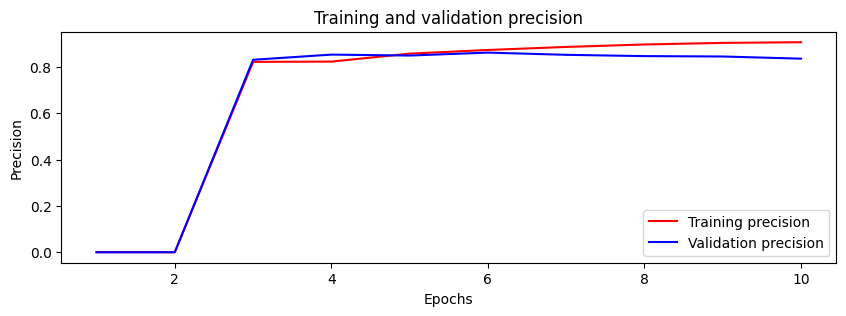

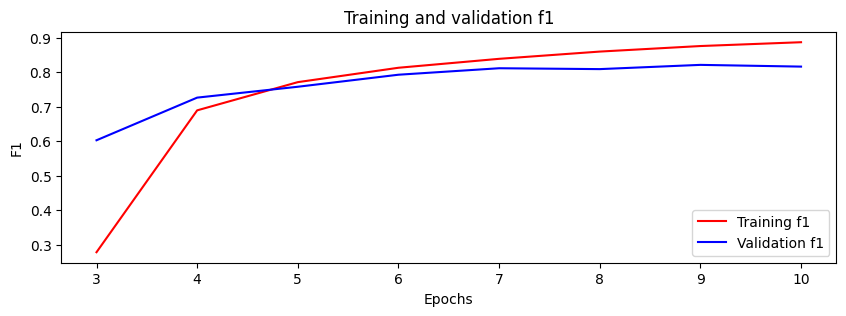

In [20]:
loss = history_dict['loss']
val_loss = history_dict['val_loss']

accuracy = history_dict['binary_accuracy']
val_accuracy = history_dict['val_binary_accuracy']

recall = history_dict['recall']
val_recall = history_dict['val_recall']

precision = history_dict['precision']
val_precision = history_dict['val_precision']

f1 = [2 * i * j / (i + j) if (i + j) > 0 else None for i,j in zip(recall, precision) ]
val_f1 = [2 * i * j / (i + j) if (i + j) > 0 else None for i,j in zip(val_recall, val_precision)]

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()
plt.close()

fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation metric')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()
plt.close()

fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
plt.plot(epochs, recall, 'r', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend(loc='lower right')
plt.show()
plt.close()

fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
plt.plot(epochs, precision, 'r', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend(loc='lower right')
plt.show()
plt.close()

fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
plt.plot(epochs, f1, 'r', label='Training f1')
plt.plot(epochs, val_f1, 'b', label='Validation f1')
plt.title('Training and validation f1')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.legend(loc='lower right')
plt.show()
plt.close()

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [21]:
sample_text = ('Bank of America hit with $250M in fines and refunds for double-dipping fees and fake accounts.')
predictions = model.predict(np.array([sample_text]))
predictions

1/1 [==============================] - 2s 2s/step


array([[-2.1897092]], dtype=float32)

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/layered_bidirectional.png?raw=1)

In [22]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=metrics)

In [24]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
165/165 [==============================] - 39s 130ms/step - loss: 0.6558 - binary_accuracy: 0.6997 - recall: 0.1628 - precision: 0.8330 - val_loss: 0.6225 - val_binary_accuracy: 0.6542 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/10
165/165 [==============================] - 5s 33ms/step - loss: 0.5811 - binary_accuracy: 0.6594 - recall: 0.0039 - precision: 0.8750 - val_loss: 0.5154 - val_binary_accuracy: 0.6646 - val_recall: 0.0331 - val_precision: 0.9167
Epoch 3/10
165/165 [==============================] - 6s 39ms/step - loss: 0.4560 - binary_accuracy: 0.7727 - recall: 0.4451 - precision: 0.8014 - val_loss: 0.4080 - val_binary_accuracy: 0.8104 - val_recall: 0.5934 - val_precision: 0.8074
Epoch 4/10
165/165 [==============================] - 5s 33ms/step - loss: 0.3558 - binary_accuracy: 0.8503 - recall: 0.6953 - precision: 0.8393 - val_loss: 0.3603 - val_binary_accuracy: 0.8490 - val_recall: 0.7078 - val_precision: 0.8304
Epoch 5/10
165/165 [==============

In [25]:
loss, accuracy, recall, precision = model.evaluate(test_dataset)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1: {2 * recall * precision / (recall + precision)}')

41/41 [==============================] - 1s 13ms/step - loss: 0.4066 - binary_accuracy: 0.8720 - recall: 0.7813 - precision: 0.8499
Loss: 0.40656572580337524
Accuracy: 0.8719512224197388
Recall: 0.781316339969635
Precision: 0.8498845100402832
F1: 0.8141592799899817


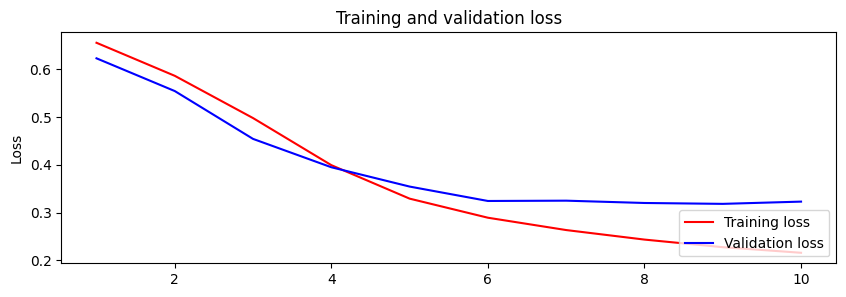

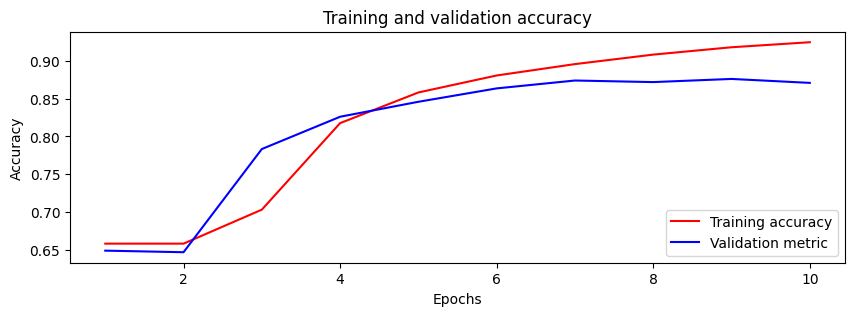

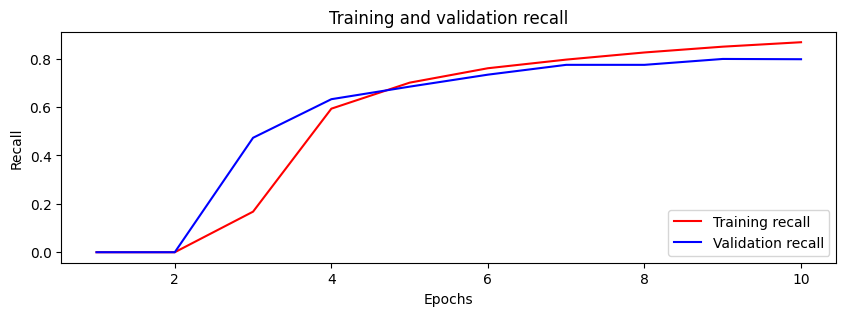

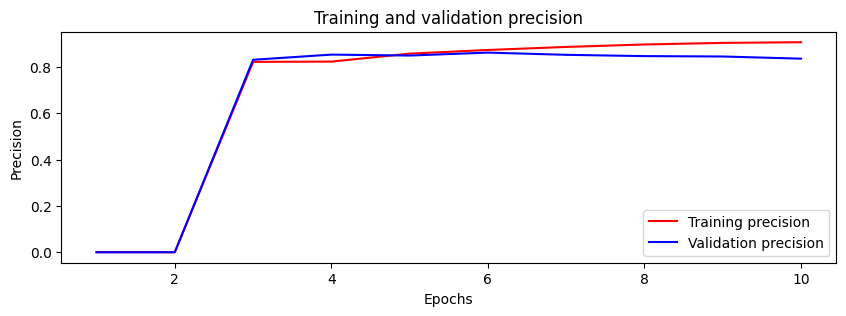

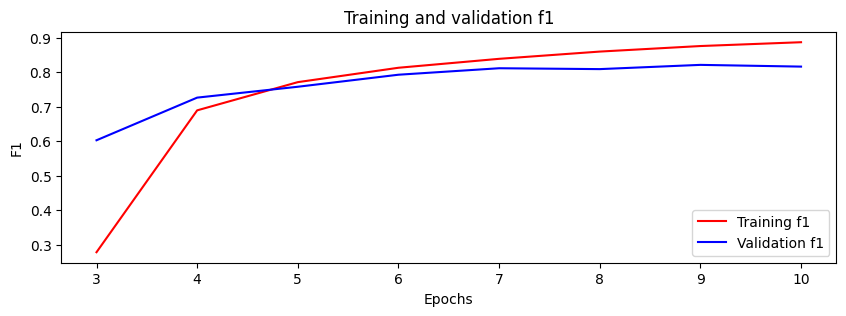

In [26]:
loss = history_dict['loss']
val_loss = history_dict['val_loss']

accuracy = history_dict['binary_accuracy']
val_accuracy = history_dict['val_binary_accuracy']

recall = history_dict['recall']
val_recall = history_dict['val_recall']

precision = history_dict['precision']
val_precision = history_dict['val_precision']

f1 = [2 * i * j / (i + j) if (i + j) > 0 else None for i,j in zip(recall, precision) ]
val_f1 = [2 * i * j / (i + j) if (i + j) > 0 else None for i,j in zip(val_recall, val_precision)]

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()
plt.close()

fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation metric')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()
plt.close()

fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
plt.plot(epochs, recall, 'r', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend(loc='lower right')
plt.show()
plt.close()

fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
plt.plot(epochs, precision, 'r', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend(loc='lower right')
plt.show()
plt.close()

fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
plt.plot(epochs, f1, 'r', label='Training f1')
plt.plot(epochs, val_f1, 'b', label='Validation f1')
plt.title('Training and validation f1')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.legend(loc='lower right')
plt.show()
plt.close()